## Code produit avec l'article: 
https://medium.com/h7w/implementing-a-variational-autoencoder-with-keras-e19d7140ad90

### Ajout dans les prédictions de la carte latente, qui permet donc de faire des prédictions sur un image dans son intégralité

In [36]:
from keras.layers import Conv1D, Input, Flatten, Dense, MaxPooling1D, BatchNormalization, Concatenate
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from PIL import Image
import numpy as np
import keras
import os
import re



# Importation des images

In [42]:
# Dossier contenant les images
repertoire = "../Render/captures"
img_width, img_height = 30, 30

# Expression pour extraire les infos du nom de fichier
#pattern = re.compile(r"img_tv(\d+)_pv(\d+)_tl(\d+)_pl(\d+)\.png") #all
pattern = re.compile(r"img_tv45_pv(\d+)_tl(\d+)_pl(\d+)\.jpeg") #les images avec tv = 45 (la latitude moyenne)

# Stockage des résultats
images_info = []

for nom_fichier in os.listdir(repertoire):
    if nom_fichier.endswith(".jpeg"):
        match = pattern.match(nom_fichier)
        if match:
            #tv, pv, tl, pl = match.groups()
            pv, tl, pl = match.groups()
            chemin_image = os.path.join(repertoire, nom_fichier)
            image = Image.open(chemin_image)
            #image = Image.open(chemin_image).crop((0, 0, img_width, img_height))
            pixels = np.array(image, dtype=np.uint8)

            images_info.append({
                "tl": int(tl),
                "pl": int(pl),
                #"tv": int(tv),
                "tv": int(45),
                "pv": int(pv),
                "image": image,
                "pixels": pixels,
            })
        #else:
            #print(f"Nom de fichier ignoré : {nom_fichier}")

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, tv={info['tv']}, pv={info['pv']}")

tl=30, pl=330, tv=45, pv=100
tl=75, pl=30, tv=45, pv=0
tl=45, pl=80, tv=45, pv=100
tl=75, pl=285, tv=45, pv=20
tl=60, pl=198, tv=45, pv=80


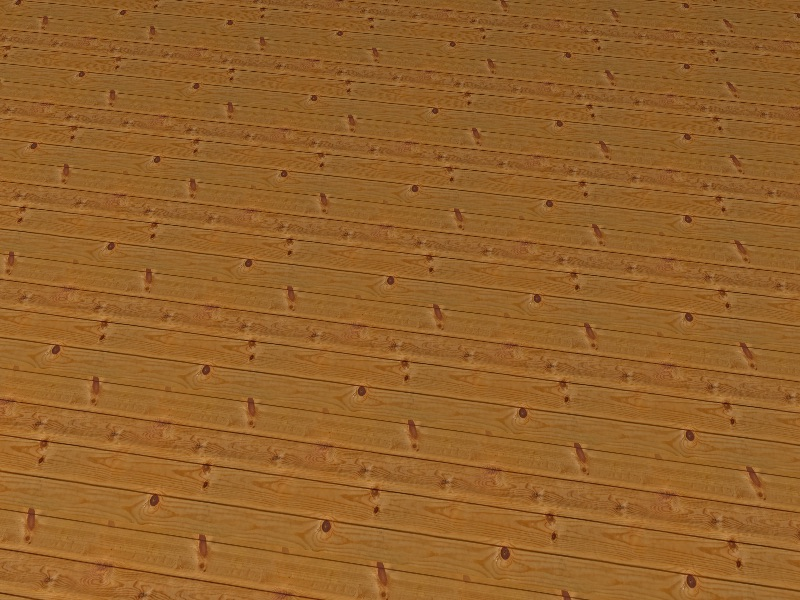

In [43]:
images_info[2]['image']

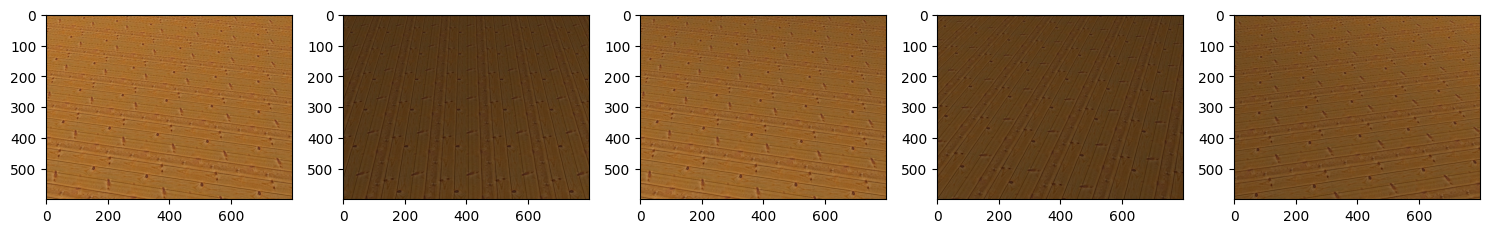

In [44]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# On trie la liste

In [45]:
images_info.sort(key=lambda d: (d["tv"], d["pv"], d["tl"], d["pl"]))

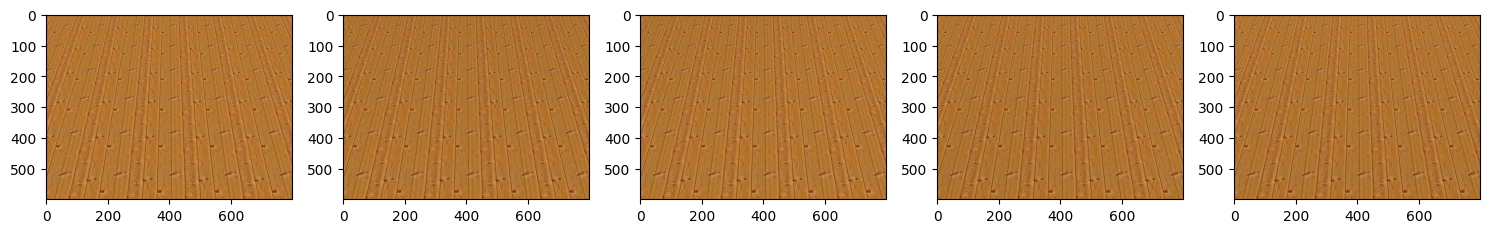

In [46]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

In [47]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [178 120  57]
Nombre d'images importées: 1458


# Création du modèles

In [ ]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
input_shape = (samples, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1
x = Conv1D(filters = 64, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bloc 2
x = Conv1D(filters = 128, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bloc 3
x = Conv1D(filters = 256, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bloc 4
x = Conv1D(filters = 512, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder_model_light = Model(inputs=i, outputs=latent_output, name="EncoderLight")
encoder_model_light.summary()


Model: "EncoderLight"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 1458, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1458, 512)      │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1458, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 729, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 373248)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_output (Dense)           │ (None, 8)              │     2,985,992 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,993,160 (11.42 MB)

 Trainable params: 2,992,136 (11.41 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [49]:
# =================
# Decoder
# =================

# Paramètres
angle_dim = 4  # 2 pour vue + 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 4 = 12

# Entrée
decoder_input = Input(shape=(input_dim,), name='decoder_input')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model = Model(inputs=decoder_input, outputs=decoder_output, name="Decoder")
decoder_model.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 106)            │         1,378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rgb_output (Dense)              │ (None, 3)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,725 (139.55 KB)

 Trainable params: 35,725 (139.55 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# =================
# VAE
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder_model_light(i)
decoder_input = Concatenate()([latent_vector, view_light_input])
vae_outputs = decoder_model(decoder_input)

vae = Model(inputs=[i, view_light_input], outputs=vae_outputs, name='VAE')
vae.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 1458, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncoderLight        │ (None, 8)         │  2,993,160 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12)        │          0 │ EncoderLight[0][… │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 3)         │     35,725 │ concatenate[0][0] │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,028,885 (11.55 MB)

 Trainable params: 3,027,861 (11.55 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [51]:
# --- L2 Loss ---
def custom_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


In [52]:
def spherical_to_cartesian(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

def stereographic_projection(x, y, z):
    # Normaliser
    norm = np.sqrt(x**2 + y**2 + z**2) + 1e-8
    x, y, z = x / norm, y / norm, z / norm
    # Projection stéréographique
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)
    return px, py

def angles_to_stereographic(theta, phi):
    x, y, z = spherical_to_cartesian(theta, phi)
    return stereographic_projection(x, y, z)


In [53]:
def angles_to_stereographic_batch(theta_array, phi_array):
    x = np.sin(theta_array) * np.cos(phi_array)
    y = np.sin(theta_array) * np.sin(phi_array)
    z = np.cos(theta_array)

    # Projection stéréographique
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)

    return np.stack([px, py], axis=1)  # shape: (N, 2)

# Compilation et entraînement
Sur un seul texel pour commencer

In [54]:
# on prend toutes les images
image_stack = np.stack([info["pixels"] for info in images_info], axis=0)
# image_stack.shape = (N_images, height, width, 3)

In [55]:
# on fait de même avec les angles
tl_stack = np.stack([info["tl"] for info in images_info], axis=0)
pl_stack = np.stack([info["pl"] for info in images_info], axis=0)
tv_stack = np.stack([info["tv"] for info in images_info], axis=0)
pv_stack = np.stack([info["pv"] for info in images_info], axis=0)

In [56]:
tl_stack.shape, pl_stack.shape, tv_stack.shape, pv_stack.shape

((1458,), (1458,), (1458,), (1458,))

In [57]:
custom_optimizer = Adam(learning_rate=0.1) # Adam est une version améliorée de la descente de gradient stochastique
# Par défaut on avait 0.001
vae.compile(custom_optimizer, loss=lambda y_true, y_pred: 0.5 * custom_reconstruction_loss(y_true, y_pred))

# Choisir UN texel
texel_position = (0, 0)
texel_observations = image_stack[:, texel_position[0], texel_position[1]]

input_train_batch = np.expand_dims(texel_observations, axis=0)

# Convertir en radians
tl_rad = np.radians(tl_stack)
pl_rad = np.radians(pl_stack)
tv_rad = np.radians(tv_stack)
pv_rad = np.radians(pv_stack)

# Générer les directions
camera_dirs = angles_to_stereographic_batch(tv_rad, pv_rad)
light_dirs = angles_to_stereographic_batch(tl_rad, pl_rad)
view_light_train = np.hstack([camera_dirs, light_dirs])  

# Définir la cible : les mêmes observations RGB utilisées comme cibles
target_rgb_train = texel_observations  # (31, 3)

# Entraînement (batch de 31 directions, batch_size=31)
history_vae = vae.fit([np.repeat(input_train_batch, samples, axis=0), view_light_train], target_rgb_train,
        epochs=100, batch_size=5, validation_split=0.2)

Epoch 1/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 85325733888.0000 - val_loss: 20077.1543
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 15974.4287 - val_loss: 20073.7148
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 16181.0898 - val_loss: 20068.9805
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 16310.4688 - val_loss: 20063.0117
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 16582.3340 - val_loss: 20055.7598
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 15853.1133 - val_loss: 20047.2129
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 16043.6748 - val_loss: 20037.1875
Epoch 8/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 16864.7773 - val_loss: 20025.5977
Epoch 9/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 16267.6455 - val_loss: 20012.3555
Epoch 10/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 16064.3818 - val_loss: 19997.1309
Epoch 11/100
234/234 ━━━━━━━━━━━

dict_keys(['loss', 'val_loss'])


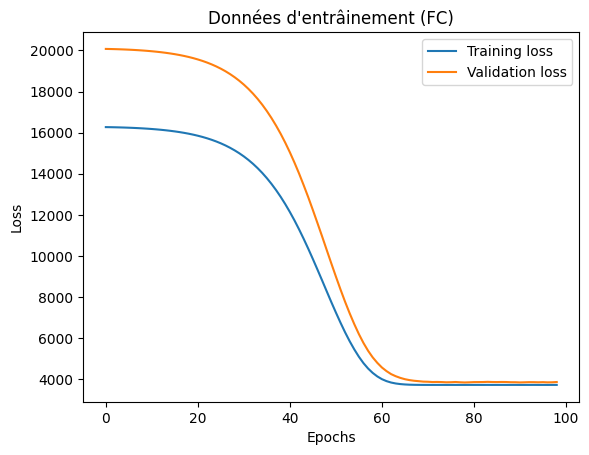

In [68]:
# Evaluer l'apprentissage d'un modèle --Code: Patrick Reuter--
def montrerCourbesApprentissage(history):
    #list all data in history
    print(history.history.keys())

    plt.plot(history.history['loss'][1:], label="Training loss")
    plt.plot(history.history['val_loss'][1:], label="Validation loss")

    plt.title("Données d'entrâinement (FC)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

montrerCourbesApprentissage(history_vae)

In [60]:
# Générer carte latente composée de tous les vecteurs latent par texel
latent_map = np.zeros((img_height, img_width, latent_dim), dtype=np.float32)

for y in range(img_height):
    for x in range(img_width):
        texel_observations = image_stack[:, y, x, :]  # (N, 3)
        input_train_batch = np.expand_dims(texel_observations, axis=0)  # (1, N, 3)
        latent_vector = encoder_model_light.predict(input_train_batch, verbose=0)[0]  # (8,)
        latent_map[y, x] = latent_vector

In [17]:
def predict_from_latent(latent_vector, view_light_direction):
    """
    latent_vector: (8,) numpy array - vecteur latent déjà calculé
    view_light_direction: (4,) numpy array - direction vue + lumière stéréographiée
    """
    decoder_input = np.concatenate([latent_vector, view_light_direction])[np.newaxis, :]  # (1, 12)
    rgb = decoder_model.predict(decoder_input)  # (1, 3)
    return rgb[0]

In [63]:
def predict_image_from_latent(latent_map, direction_4d):
    """
    latent_map: (H, W, 8) carte des vecteurs latents
    direction_4d: (4,) stéréographique [vx, vy, lx, ly]
    """
    H, W, latent_dim = latent_map.shape
    decoder_input = np.zeros((H * W, latent_dim + 4), dtype=np.float32)

    # Flatten latent map
    latent_flat = latent_map.reshape(-1, latent_dim)  # (H*W, 8)

    # Répéter direction pour tous les texels
    dir_repeated = np.repeat(direction_4d[np.newaxis, :], H * W, axis=0)  # (H*W, 4)

    # Concaténer
    decoder_input = np.concatenate([latent_flat, dir_repeated], axis=1)  # (H*W, 12)

    # Prédiction
    predicted_rgb_flat = decoder_model.predict(decoder_input, verbose=0)  # (H*W, 3)
    predicted_image = predicted_rgb_flat.reshape(H, W, 3).astype(np.uint8)
    return predicted_image

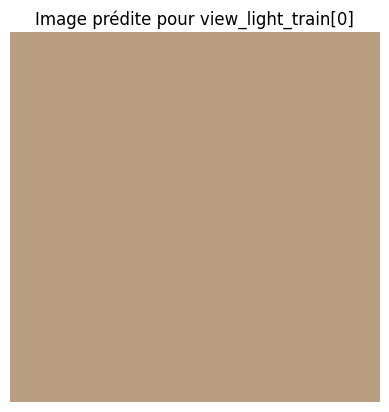

In [64]:
direction = view_light_train[0]  # (4,)
predicted_image = predict_image_from_latent(latent_map, direction)

plt.imshow(predicted_image)
plt.title("Image prédite pour view_light_train[0]")
plt.axis('off')
plt.show()

In [65]:
def show_comparison(predicted_image, ground_truth_image):
    # Différence absolue par pixel
    diff_image = np.abs(predicted_image.astype(np.int16) - ground_truth_image.astype(np.int16))

    # Affichage
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(predicted_image)
    axs[0].set_title("Image prédite")
    axs[0].axis('off')

    axs[1].imshow(ground_truth_image)
    axs[1].set_title("Image réelle")
    axs[1].axis('off')

    axs[2].imshow(diff_image)
    axs[2].set_title("Différence absolue")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

In [66]:
# Afficher la comparaison entre les images
index = 0

direction = view_light_train[index]
predicted_image = predict_image_from_latent(latent_map, direction)
ground_truth_image = image_stack[index]  # (H, W, 3)

show_comparison(predicted_image, ground_truth_image)

ValueError: operands could not be broadcast together with shapes (30,30,3) (600,800,3) 